## In this notebook, we will perform some statistical tests on preprocessed breast cancer dataset

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import norm, shapiro, levene

In [2]:
# Load the dataset
file_path = '/kaggle/input/breastcancer-preprocessed/BreastCancer-Preprocessed.csv'
df = pd.read_csv(file_path)

##  Display the first few rows of the dataset to understand its structure

In [3]:
df.head()

,id,age,pathsize,lnpos,histgrad,er,pr,status,time,lnpos_YN,pathsize_Cat
0,1.0,60.0,NaN,0.0,3.0,0.0,0.0,0.0,9.466667,No,NaN
1,2.0,79.0,NaN,0.0,NaN,NaN,NaN,0.0,8.600000,No,NaN
2,3.0,82.0,NaN,0.0,2.0,NaN,NaN,0.0,19.333333,No,NaN
3,4.0,66.0,NaN,0.0,2.0,1.0,1.0,0.0,16.333333,No,NaN
4,5.0,52.0,NaN,0.0,3.0,NaN,NaN,0.0,8.500000,No,NaN


## Understanding the Variables

The `lnpos_YN` and `status` are categorical variables that we want to test for independence.
Let's take a look at the unique values in these columns.

In [4]:
# Check the unique values in 'lnpos_YN' and 'status'
print("Unique values in 'lnpos_YN':", df['lnpos_YN'].unique())
print("Unique values in 'status':", df['status'].unique())


Unique values in 'lnpos_YN': ['No' 'Yes']
Unique values in 'status': [0. 1.]


## Creating a Contingency Table

We will create a contingency table to summarize the relationship between the two categorical variables.

In [5]:
# Create a contingency table
contingency_table = pd.crosstab(df['lnpos_YN'], df['status'])
contingency_table


status,0.0,1.0
lnpos_YN,,
No,887,42
Yes,248,30


In [6]:
# Calculate row-wise percentages
row_percentage = contingency_table.apply(lambda x: x / x.sum() * 100, axis=1)
row_percentage

status,0.0,1.0
lnpos_YN,,
No,95.479010,4.520990
Yes,89.208633,10.791367


## Performing the Chi-Square Test for Independence

The Chi-Square Test for Independence will help us determine whether there is a significant association between `lnpos_YN` and `status`.


In [7]:
# Perform the Chi-Square Test for Independence
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("***********************************")
print("p-value:", p)
print("***********************************")
print("Degrees of Freedom:", dof)
print("***********************************")
print("Expected Frequencies Table:\n", expected)

Chi-Square Statistic: 13.900758213995182
***********************************
p-value: 0.00019272070767964805
***********************************
Degrees of Freedom: 1
***********************************
Expected Frequencies Table:
 [[873.58326429  55.41673571]
 [261.41673571  16.58326429]]


## Interpreting the Results

- **Chi-Square Statistic**: A measure of how much the observed counts deviate from the expected counts.
- **p-value**: The probability of obtaining a Chi-Square statistic at least as extreme as the one computed, assuming that the variables are independent.
- **Degrees of Freedom**: Number of values that are free to vary given the constraints.
- **Expected Frequencies Table**: The expected counts if the variables are truly independent.

If the p-value is less than our significance level (typically 0.05), we reject the null hypothesis and conclude that there is a significant association between `lnpos_YN` and `status`.


## Calculate the residuals

In [8]:
# Calculate the residuals
residuals = (contingency_table - expected)
print("Residuals:\n", residuals)

Residuals:
 status          0.0        1.0
lnpos_YN                      
No        13.416736 -13.416736
Yes      -13.416736  13.416736


## Interpreting the Residuals

Residuals show the difference between observed and expected frequencies, standardized by the expected frequency. Large residuals indicate cells that contribute significantly to the Chi-Square statistic.


## Calculating the Odds Ratio

The odds ratio will provide a measure of association between the two categorical variables. Note that the odds ratio is only appropriate for 2x2 tables.


In [9]:
   # Check if the table is 2x2
if contingency_table.shape == (2, 2):
    # Extract values from the contingency table
    a = contingency_table.iloc[0, 0]
    b = contingency_table.iloc[0, 1]
    c = contingency_table.iloc[1, 0]
    d = contingency_table.iloc[1, 1]
    
    # Calculate the Odds Ratio
    odds_ratio = (a / b) / (c / d)
    
    log_OddsRatio = np.log(odds_ratio)
    _log_or = np.sqrt(1/a + 1/b + 1/c + 1/d)
    
    # 95% Confidence interval for odds ratio
    z = norm.ppf(0.975)
    CI_lower = np.exp(log_OddsRatio - z * _log_or)
    CI_upper = np.exp(log_OddsRatio + z * _log_or)
    
    # Output results
    print(f"Odds Ratio: {odds_ratio:.2f}")
    print(f"95% Confidence Interval (CI): ({CI_lower:.4f}, {CI_upper:.4f})")
    
     

Odds Ratio: 2.55
95% Confidence Interval (CI): (1.5663, 4.1668)


## Interpreting the Results

- **Odds Ratio**: Measure of association between the two variables, applicable for 2x2 tables.
- **95% Confidence interval for odds ratio** : A confidence interval (CI) provides a range of values that is likely to contain the population parameter with a certain level of confidence (usually 95%). 


## The Fisher Exact Test 

In [10]:
# Fisher is typically used when sample sizes are small, especially when the expected frequency in any of the cells of a contingency table is less than 5
# Check if any expected frequency is less than 5

if (expected < 5).any():
    print("At least one expected frequency is less than 5. Performing Fisher Exact Test.")
    
    # Fisher Exact Test can only be performed on 2x2 tables
    if contingency_table.shape == (2, 2):
        oddsratio, p_fisher = stats.fisher_exact(contingency_table)
        print("Fisher Exact Test p-value:", p_fisher)
    else:
        print("Fisher Exact Test is not applicable for tables larger than 2x2.")
else:
    print("All expected frequencies are 5 or greater. Performing Chi-Square Test for Independence.")
    


All expected frequencies are 5 or greater. Performing Chi-Square Test for Independence.


## Independent t test

In [11]:
df.lnpos_YN.value_counts()


lnpos_YN
No     929
Yes    278
Name: count, dtype: int64

In [12]:
df[df['lnpos_YN'] == 'Yes']['time']

8        27.633333
9        11.133333
10       11.066667
20      107.800000
27       48.666667
           ...    
1200     33.700000
1201     32.366667
1202      6.866667
1204     15.166667
1205     45.133333
Name: time, Length: 278, dtype: float64

In [13]:
groupY =df[df['lnpos_YN'] == 'Yes']['time']
groupN = df[df['lnpos_YN'] == 'No']['time']


**Check normality**

In [14]:
sh_lnpose_Y = stats.shapiro(groupY)
sh_lnpose_N = stats.shapiro(groupN)
print(sh_lnpose_N)
print(sh_lnpose_Y)

ShapiroResult(statistic=0.958610475063324, pvalue=1.531057368424826e-15)
ShapiroResult(statistic=0.9339127540588379, pvalue=8.318342126223399e-10)


In [15]:
levene1 = levene(groupN,groupY)
levene1

LeveneResult(statistic=1.1169212722022501, pvalue=0.29079417684064907)

In [16]:
if levene1.pvalue > 0.05 :
    t_statistics , p_value = stats.ttest_ind(groupN,groupY,equal_var=True)
    print('H0 is acceptible and variances are equal in lnpose_YN and Time')
else:
    t_statistics , p_value = stats.ttest_ind(groupN,groupY, equal_var=False)
    print('H1 is acceptible and variances are not equal in lnpose_YN and Time')

H0 is acceptible and variances are equal in lnpose_YN and Time


In [17]:
pathsize_groups = df['pathsize_Cat'].dropna().unique()
pathsize_groups

array(['<= 2', '2 <  <= 5', '> 5'], dtype=object)

In [18]:
df[df['pathsize_Cat'] == pathsize_groups[0]]

,id,age,pathsize,lnpos,histgrad,er,pr,status,time,lnpos_YN,pathsize_Cat
86,14.0,44.0,0.10,1.0,NaN,NaN,NaN,0.0,108.900000,Yes,<= 2
87,15.0,60.0,0.15,0.0,1.0,1.0,1.0,0.0,16.366667,No,<= 2
88,16.0,49.0,0.20,0.0,1.0,NaN,NaN,0.0,94.333333,No,<= 2
89,17.0,41.0,0.20,0.0,1.0,NaN,NaN,0.0,87.500000,No,<= 2
90,18.0,39.0,0.26,0.0,2.0,NaN,NaN,0.0,73.033333,No,<= 2
...,...,...,...,...,...,...,...,...,...,...,...
907,1249.0,38.0,2.00,0.0,2.0,NaN,NaN,1.0,25.433333,No,<= 2
908,1252.0,29.0,1.50,1.0,3.0,NaN,0.0,0.0,35.666667,Yes,<= 2
909,1256.0,59.0,1.20,0.0,NaN,1.0,0.0,0.0,133.800000,No,<= 2
910,1261.0,41.0,1.20,0.0,2.0,1.0,1.0,0.0,90.166667,No,<= 2


In [19]:
for level, group in df.groupby('pathsize_Cat'):
     groupN = group[group['lnpos_YN'] == 'No']['time']
     groupY = group[group['lnpos_YN'] == 'Yes']['time']
 

In [20]:
shapiro_pathsize_group1 = shapiro(groupN)
shapiro_pathsize_group2 = shapiro(groupY)

# Check homogeneity of variances for pathsize_Cat groups
levene_pathsize = levene(groupN, groupY)

# Perform pairwise t-tests based on Levene's test result
if levene_pathsize.pvalue > 0.05:
    # Use equal variances
    t_statistic_1, p_value_1 = stats.ttest_ind(groupN, groupY, equal_var=True)
else:
    # Use unequal variances
    t_statistic_1, p_value_1 = stats.ttest_ind(groupN, groupY, equal_var=False)

# Print results


print(f'Shapiro test for pathsize_Cat group1: {shapiro_pathsize_group1}')
print(f'Shapiro test for pathsize_Cat group2: {shapiro_pathsize_group2}')
print(f'Levene test for pathsize_Cat: {levene_pathsize}')
print(f'T-Test for pathsize_Cat: t_statistic = {t_statistic_1}, p_value = {p_value_1}')

Shapiro test for pathsize_Cat group1: ShapiroResult(statistic=0.9486790895462036, pvalue=0.7078753113746643)
Shapiro test for pathsize_Cat group2: ShapiroResult(statistic=0.9288694262504578, pvalue=0.5058420300483704)
Levene test for pathsize_Cat: LeveneResult(statistic=0.05583725989193762, pvalue=0.8179702620924999)
T-Test for pathsize_Cat: t_statistic = -0.3014836920469003, p_value = 0.7692217601243535


## ANOVA Test

* ANOVA (Analysis of Variance) is a statistical method used to compare means of three or more samples to understand if at least one sample mean is significantly different from the others. Here, we will perform ANOVA to analyze if there is a significant difference in the means of the time variable across different histgrad categories.

* **Steps**

**1. Handling Missing Data and Values**
* Check and handle missing data in histgrad and time.

**2. Checking Assumptions for ANOVA**
*  Normality: Each group's time should be approximately normally distributed.
*  Homogeneity of variances: The variances across groups should be approximately equal.

**3. Performing ANOVA**
* Use Python's scipy.stats library to perform the ANOVA test.

**4. Interpreting Results**
* Understanding the ANOVA output and making conclusions.

**Step 1**

In [21]:
missing_data = df[['histgrad', 'time']].isnull().sum()
missing_data

histgrad    287
time          0
dtype: int64

In [22]:
cleaned_data = df.dropna(subset=['histgrad'])
cleaned_data

,id,age,pathsize,lnpos,histgrad,er,pr,status,time,lnpos_YN,pathsize_Cat
0,1.0,60.0,NaN,0.0,3.0,0.0,0.0,0.0,9.466667,No,NaN
2,3.0,82.0,NaN,0.0,2.0,NaN,NaN,0.0,19.333333,No,NaN
3,4.0,66.0,NaN,0.0,2.0,1.0,1.0,0.0,16.333333,No,NaN
4,5.0,52.0,NaN,0.0,3.0,NaN,NaN,0.0,8.500000,No,NaN
6,7.0,50.0,NaN,0.0,2.0,1.0,0.0,0.0,17.666667,No,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1202,1038.0,37.0,5.5,5.0,3.0,0.0,0.0,0.0,6.866667,Yes,> 5
1203,1039.0,64.0,6.0,0.0,3.0,0.0,1.0,0.0,15.766667,No,> 5
1204,1041.0,57.0,6.5,7.0,3.0,1.0,1.0,0.0,15.166667,Yes,> 5
1205,1202.0,51.0,5.5,11.0,2.0,0.0,0.0,1.0,45.133333,Yes,> 5


In [23]:
cleaned_data.shape

(920, 11)

**Step 2**

We need to check if the time variable is normally distributed for each histgrad group. We can use the Shapiro-Wilk test for normality and Levene's test to check for equality of variances.

In [24]:
from scipy.stats import shapiro, levene

In [25]:
# Check for normality using Shapiro-Wilk test
for i in cleaned_data['histgrad'].unique():
    stat, p = shapiro(cleaned_data[cleaned_data['histgrad'] == i]['time'])
    print(f'Histgrad {i}: Stat={stat:.3f}, p={p:.3f}')

# Check for homogeneity of variances using Levene's test
stat, p = levene(
   cleaned_data[cleaned_data['histgrad'] == 1.0]['time'],
    cleaned_data[cleaned_data['histgrad'] == 2.0]['time'],
    cleaned_data[cleaned_data['histgrad'] == 3.0]['time']
)
print(f'Levene’s Test: Stat={stat:.3f}, p={p:.3f}')

Histgrad 3.0: Stat=0.944, p=0.000
Histgrad 2.0: Stat=0.962, p=0.000
Histgrad 1.0: Stat=0.958, p=0.011
Levene’s Test: Stat=0.432, p=0.650


* The Shapiro-Wilk test results indicate that the time variable is not normally distributed for any of the histgrad groups (all p-values are less than 0.05, indicating a violation of the normality assumption).


*  The p-value for Levene's test is 0.650, which is greater than 0.05, indicating that the assumption of homogeneity of variances is met.

Even though ANOVA is robust to deviations from normality, particularly with large sample sizes, it's good to be aware of this violation. For more robust analysis, non-parametric tests like the Kruskal-Wallis test can be considered. However, we'll proceed with ANOVA for the purpose of learning.

**Step 3**
* Performing ANOVA
We can now perform the ANOVA test using the f_oneway function from scipy.stats.

In [26]:
from scipy.stats import f_oneway
avova_result = f_oneway(    
    cleaned_data[cleaned_data['histgrad'] == 1.0]['time'],
    cleaned_data[cleaned_data['histgrad'] == 2.0]['time'],
    cleaned_data[cleaned_data['histgrad'] == 3.0]['time']
)
avova_result

F_onewayResult(statistic=6.9885425713625615, pvalue=0.0009723280343059178)

* The ANOVA test results are as follows:

F-statistic: 6.99
p-value: 0.00097

**Step 4**

Since the p-value is much less than 0.05, we reject the null hypothesis that the means of time are equal across different histgrad groups. This indicates that there is a statistically significant difference in time among the different histgrad levels.

**Summary** :
Here are the steps we took to perform the ANOVA test:

* Handled missing values by removing rows with missing histgrad values.
* Checked assumptions for ANOVA:
* Normality using the Shapiro-Wilk test (not met, but we proceeded due to the robustness of ANOVA).
* Homogeneity of variances using Levene's test (met).
* Performed ANOVA using the f_oneway function.
* Interpreted the results, concluding that there is a significant difference in time among different histgrad groups.

**To determine which specific groups have different means, you can perform a post-hoc test after finding a significant result with ANOVA.**

In [27]:
pip install scikit-posthocs

Note: you may need to restart the kernel to use updated packages.


In [28]:
from scikit_posthocs import posthoc_ttest
import scikit_posthocs as sp

In [29]:
# Perform pairwise t-tests with Bonferroni correction
posthoc_result = sp.posthoc_ttest(cleaned_data, val_col='time', group_col='histgrad', p_adjust='bonferroni')

# Display the results
print(posthoc_result)

          3.0       2.0       1.0
3.0  1.000000  0.000699  0.157949
2.0  0.000699  1.000000  1.000000
1.0  0.157949  1.000000  1.000000


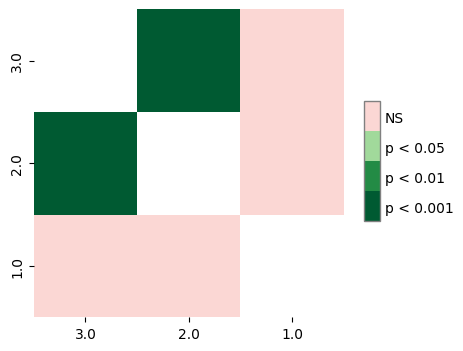

In [30]:
import matplotlib.pyplot as plt
import scikit_posthocs as sp

plt.figure(figsize=(4, 4))
sp.sign_plot(posthoc_result)

plt.show()

## Correlation Coefficient Tests ( Pearson and Spearman )

Correlation coefficients are statistical measures that describe the strength and direction of a relationship between two variables. The most common types of correlation coefficients are Pearson's, Spearman's, and Kendall's tau.

**Pearson Correlation Coefficient**

Pearson's correlation coefficient measures the linear relationship between two variables. The value ranges from -1 to 1:

* 1 means a perfect positive linear relationship.
* -1 means a perfect negative linear relationship.
* 0 means no linear relationship.

First of all with scatter plot i want to check if there is any correlation between 'age' and 'time' or not?!
Then for learning, i do the test

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

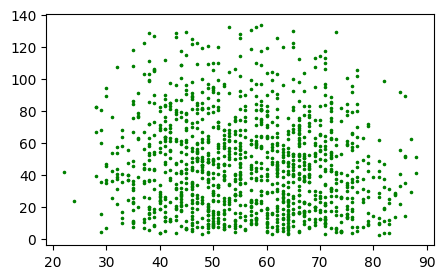

In [32]:
fig , ax = plt.subplots(nrows=1 , ncols=1 , figsize=(5,3))
ax.scatter(df['age'] , df['time'] , marker='.' , s=10, c = 'green')

As you see there isn't any correlation between them, but i continoue

In [33]:
# here i do a shapiro test for checking normality for time
stat_time , p_value_time = shapiro(df['time'])

print("Stat of our time metric : ",stat_time)
print("P_value of our time metric : " , p_value_time)

Stat of our time metric :  0.954105794429779
P_value of our time metric :  5.460421882712611e-19


In [34]:
# here i do a shapiro test for checking normality for age
stat_age , p_value_age = shapiro(df['age'])
print("Stat of our age metric : ",stat_age)
print("P_value of our age metric : " , p_value_age)

Stat of our age metric :  0.9871929883956909
P_value of our age metric :  8.479493551760697e-09


We can see here that 'age' and 'time' aren't normal

**Doing Pearson Test**

In [35]:
corre_cof , p_value_ = pearsonr(df['time'] , df['age'])
print("Correlation Coefficient between time and age : " , corre_cof)
print("P_value : " , p_value_)

Correlation Coefficient between time and age :  -0.10225288144205594
P_value :  0.00037353441159475656


false significance or false positive is occured, so we do a Spearman test

In [36]:
from scipy.stats import spearmanr

In [37]:
corr_cof_sp , p_value_sp = spearmanr(df['time'] , df['age'])
print("Correlation Coefficient between time and age with non-parametric test named Spearman : " , corr_cof_sp)
print("P_value : " , p_value_sp)

Correlation Coefficient between time and age with non-parametric test named Spearman :  -0.09951237288803319
P_value :  0.0005356509148888753
